# Project 3: Web Scraping and Sentiment Analysis for Product Reviews

**Objective:** Create a system that can scrape product reviews from the web, perform sentiment analysis, and visualize the results.

**Tasks:**

1. Develop a web scraper to collect product reviews from an e-commerce website

2. Implement data cleaning and preprocessing for scraped data

3. Perform exploratory data analysis on collected reviews

4. Develop a sentiment analysis model (e.g., LSTM or fine-tuned DistilBERT)

5. Implement techniques to handle class imbalance

6. Perform error analysis and model interpretation

7. Create a visualization dashboard for sentiment trends




# Develop a web scraper to collect product reviews from an e-commerce website

## Dataset Description
The Reviews was obtained from the SkyTrax website, where users rate and review airline services. British Airways was selected for this analysis due to the high volume of ratings and reviews available for this airline. I scraped the reviews and created dataset. The dataset consists of 3,852 entries, each representing a review. The data includes two columns: one for the review text and another for the date the review was posted.

**Link for Web Scraping file:** https://colab.research.google.com/drive/14lGqnu7zTeseERcK8K4l_TRaBoMMBEZL#scrollTo=tmg3FUY_gNGT

In [ ]:
# Install the LIME package (run this only once)
!pip install lime
!pip install tabulate # Install the tabulate library



In [ ]:
# Importing libraries and setting up the environment
import warnings  # To handle and suppress warnings
warnings.filterwarnings('ignore')  # Suppress all warnings to avoid clutter

# Data handling libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and array handling

# Natural Language Processing (NLP) libraries
import nltk  # For various NLP tasks
import re  # For regular expression operations, often used in text cleaning
import string  # For string operations, e.g., punctuation removal

# Downloading necessary NLTK resources
nltk.download('stopwords')  # List of common stop words
nltk.download('punkt')  # Tokenizer models for splitting text into words/sentences
nltk.download('wordnet')  # WordNet lexical database for lemmatization
nltk.download('vader_lexicon')  # VADER sentiment analysis lexicon

# Importing NLTK modules for text processing
from nltk.corpus import stopwords  # Accessing stop words list
from nltk.tokenize import word_tokenize  # Tokenizing text into words
from nltk.stem import WordNetLemmatizer  # For lemmatizing words
from nltk.stem import PorterStemmer  # For stemming words

# Initializing the Porter Stemmer
porter_stemmer = PorterStemmer()

# Handling contractions
!pip install contractions  # Install contractions library to expand contractions in text
import contractions  # For expanding contractions in text

# Data visualization libraries
import matplotlib.pyplot as plt  # For creating visualizations and plots
import seaborn as sns  # For statistical data visualization
from collections import Counter  # For counting occurrences of items, e.g., word frequencies
from wordcloud import WordCloud

# Sentiment analysis and preprocessing
from nltk.sentiment import SentimentIntensityAnalyzer  # For sentiment analysis using VADER

# Machine learning libraries
from sklearn.preprocessing import LabelEncoder  # For encoding categorical labels into numerical values
from sklearn.model_selection import train_test_split  # For splitting data into training and test sets

# Deep learning libraries
import tensorflow as tf  # TensorFlow library for machine learning and deep learning
from tensorflow.keras.preprocessing.text import Tokenizer  # For tokenizing text into sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences  # For padding sequences to the same length
from tensorflow.keras.models import Sequential  # Sequential model for building neural networks
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten  # Layers for building a neural network
from tensorflow.keras.optimizers import Adam  # Adam optimizer for training neural networks
from tensorflow.keras.layers import Bidirectional  # For creating bidirectional LSTM layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # Callbacks for model training
from tensorflow.keras import regularizers  # For regularization techniques
from tensorflow.keras.regularizers import l2  # L2 regularization for weight penalties

# Handling class imbalance
from imblearn.over_sampling import SMOTE  # For oversampling the minority class
from sklearn.utils import resample  # For resampling techniques
from imblearn.under_sampling import RandomUnderSampler  # For undersampling the majority class
from sklearn.utils.class_weight import compute_class_weight  # For computing class weights to handle imbalance

# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix  # For generating classification reports, confusion matrix

# Model interpretability
from lime.lime_text import LimeTextExplainer  # For explaining predictions of text classification models
from tabulate import tabulate # Import the tabulate function






[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# *Implement data cleaning and preprocessing for scraped data*

In [ ]:
# Load the data
df = pd.read_csv('/content/British_Airway_Review.csv')
df.head()


reviews              date
0  ✅ Trip Verified |   Straightforward check in T...  30th August 2024
1  Not Verified | I am beyond upset and disgusted...  28th August 2024
2  ✅ Trip Verified |   I purchased round trip dir...  28th August 2024
3  Not Verified | I booked two business class sea...  27th August 2024
4  Not Verified | Although all four flights were ...  26th August 2024

In [ ]:
# Function to clean text
def clean_text(text):

    text = text.lower()
    text = text.replace('✅ Trip Verified |', '')  # Removes '✅ Trip Verified |' if it exists
    text = text.replace('✅ Not Verified |', '')   # Removes '✅ Not Verified |' if it exists
    text = re.sub(r'\d+', '', text)  # Removing numbers
    text = re.sub(r'[^\w\s]', '', text)  # Removing punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Removing extra whitespace
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Removing URLs
    text = re.sub(r'\w+@\w+\.\w+', '', text)  # Removing email addresses
    text = re.sub(r'<.*?>', '', text)  # Removing HTML tags
    text = contractions.fix(text)  # Expanding contractions
    text = re.sub(r"\b(not|n't)\b", 'not_', text)
    return text

# Apply text cleaning
df['cleaned_text'] = df['reviews'].apply(clean_text)

# Tokenization and Lemmatization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
custom_stop_words = stop_words.union({'one', 'two', 'product', 'company', 'service'})

def preprocess_text(text):
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in custom_stop_words]
    #words = [porter_stemmer.stem(word) for word in words]  # Adding stemming
    return ' '.join(words)


df['preprocessed_text'] = df['cleaned_text'].apply(preprocess_text)



In [ ]:
# Save the cleaned data
df.to_csv('cleaned_British_Airway.csv', index=False)
df = pd.read_csv('cleaned_British_Airway.csv')
df.head()

reviews              date  \
0  ✅ Trip Verified |   Straightforward check in T...  30th August 2024   
1  Not Verified | I am beyond upset and disgusted...  28th August 2024   
2  ✅ Trip Verified |   I purchased round trip dir...  28th August 2024   
3  Not Verified | I booked two business class sea...  27th August 2024   
4  Not Verified | Although all four flights were ...  26th August 2024   

                                        cleaned_text  \
0  trip verified straightforward check in t new s...   
1  not_ verified i am beyond upset and disgusted ...   
2  trip verified i purchased round trip direct fl...   
3  not_ verified i booked two business class seat...   
4  not_ verified although all four flights were d...   

                                   preprocessed_text  
0  trip verified straightforward check new site c...  
1  not_ verified beyond upset disgusted disregard...  
2  trip verified purchased round trip direct flig...  
3  not_ verified booked business class seat medic...  
4  not_ verified although four flight delayed off...

# *Perform exploratory data analysis on collected reviews*

In [ ]:
df.shape

(3853, 4)

In [ ]:
df['preprocessed_text'][0]

'trip verified straightforward check new site club check work well lounge busy good food offering time departure completely full flight cabin sound food drink offered exception inferior quality champagne crew coped well busy quite short flight slept hour afternoon tea food good portion small early landing luggage quickly'

In [ ]:
df['date'].head()

0    30th August 2024
1    28th August 2024
2    28th August 2024
3    27th August 2024
4    26th August 2024
Name: date, dtype: object

In [ ]:
#checking duplicates
df.duplicated().sum()

63

In [ ]:
#removing duplicates
df.drop_duplicates(inplace=True)

In [ ]:
#checking missing values
df.isna().sum()

reviews              0
date                 0
cleaned_text         0
preprocessed_text    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3790 entries, 0 to 3852
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   reviews            3790 non-null   object
 1   date               3790 non-null   object
 2   cleaned_text       3790 non-null   object
 3   preprocessed_text  3790 non-null   object
dtypes: object(4)
memory usage: 148.0+ KB


In [ ]:
df.describe()

reviews               date  \
count                                                3790               3790   
unique                                               3788               1935   
top     London Heathrow to Miami on one of British Air...  19th January 2015   
freq                                                    2                 16   

                                             cleaned_text  \
count                                                3790   
unique                                               3788   
top     london heathrow to miami on one of british air...   
freq                                                    2   

                                        preprocessed_text  
count                                                3790  
unique                                               3788  
top     london heathrow miami british airway crummy bo...  
freq                                                    2

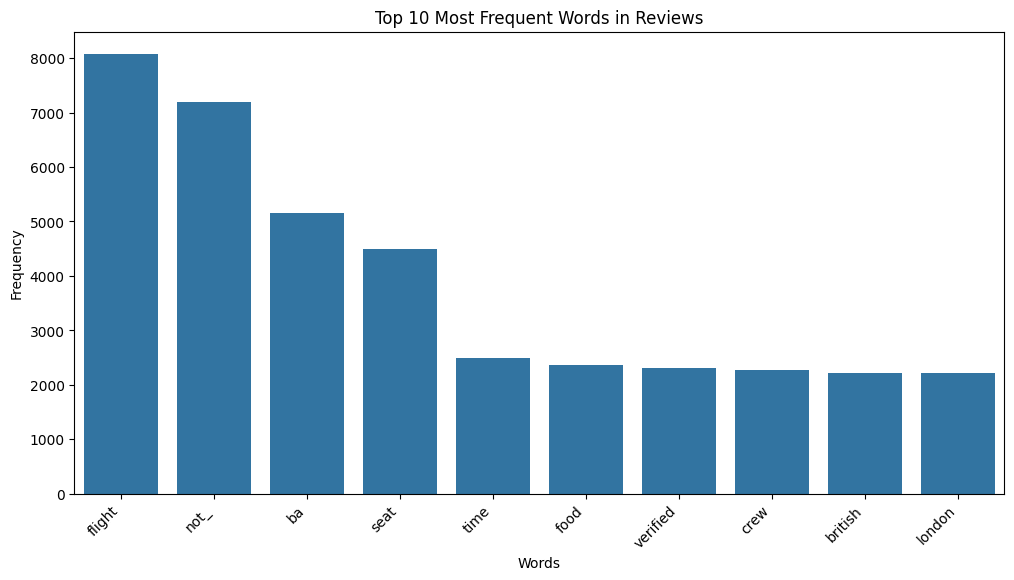

In [ ]:
# 'preprocessed_text' column contains the text of the reviews
word_counts = Counter(" ".join(df["preprocessed_text"]).split())

# Get the 10 most common words
top_10_words = word_counts.most_common(10)

# Create lists for words and their counts
words = [word for word, count in top_10_words]
counts = [count for word, count in top_10_words]

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=words, y=counts)
plt.title('Top 10 Most Frequent Words in Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()


# **Sentiment Analysis**

In [ ]:
# Initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

**Feature Engineering**

In [ ]:
#applying polarity scores to processed data
df["polarity_score"] = df["preprocessed_text"].apply(lambda x: sia.polarity_scores(x)["compound"])
df.head(10)

reviews              date  \
0  ✅ Trip Verified |   Straightforward check in T...  30th August 2024   
1  Not Verified | I am beyond upset and disgusted...  28th August 2024   
2  ✅ Trip Verified |   I purchased round trip dir...  28th August 2024   
3  Not Verified | I booked two business class sea...  27th August 2024   
4  Not Verified | Although all four flights were ...  26th August 2024   
5  ✅ Trip Verified |   Flight changed just one da...  26th August 2024   
6  Not Verified | Delayed flight 1 hour. Arbitrar...  25th August 2024   
7  Not Verified | Flown with BA four times. As an...  25th August 2024   
8  ✅ Trip Verified |   You may never see your ref...  22nd August 2024   
9  Not Verified | Cargo service: that's how I fel...  21st August 2024   

                                        cleaned_text  \
0  trip verified straightforward check in t new s...   
1  not_ verified i am beyond upset and disgusted ...   
2  trip verified i purchased round trip direct fl...   
3  not_ verified i booked two business class seat...   
4  not_ verified although all four flights were d...   
5  trip verified flight changed just one day befo...   
6  not_ verified delayed flight hour arbitrary ca...   
7  not_ verified flown with ba four times as an a...   
8  trip verified you may never see your refund i ...   
9  not_ verified cargo service that is how i felt...   

                                   preprocessed_text  polarity_score  
0  trip verified straightforward check new site c...          0.8176  
1  not_ verified beyond upset disgusted disregard...         -0.9819  
2  trip verified purchased round trip direct flig...         -0.8701  
3  not_ verified booked business class seat medic...         -0.3400  
4  not_ verified although four flight delayed off...          0.9039  
5  trip verified flight changed day british airwa...          0.2263  
6  not_ verified delayed flight hour arbitrary ca...         -0.4019  
7  not_ verified flown ba four time anxious trave...          0.4588  
8  trip verified may never see refund cancelled r...          0.6298  
9  not_ verified cargo felt upper deck supposedly...          0.9313

In [ ]:
#creating sentiment column by giving tags to processed text
df["sentiment"] = df["preprocessed_text"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df["sentiment"].value_counts()


sentiment
pos    2516
neg    1274
Name: count, dtype: int64

Length of positive reviews: 1438895
Length of negative reviews: 719873


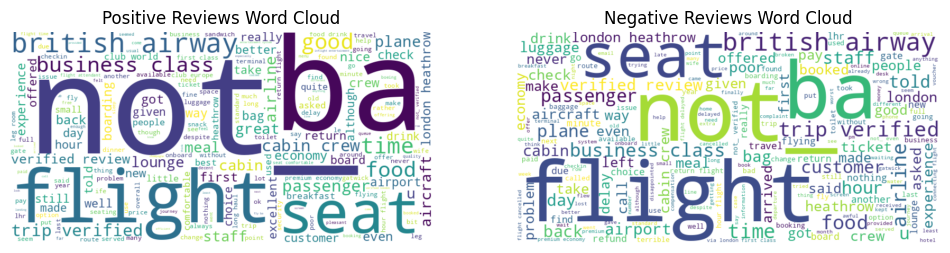

In [ ]:
# Combine all reviews by sentiment, handling the case of no reviews
positive_reviews = ' '.join(df[df['sentiment'] == 'pos']['preprocessed_text']) if 'pos' in df['sentiment'].values else ''
negative_reviews = ' '.join(df[df['sentiment'] == 'neg']['preprocessed_text']) if 'neg' in df['sentiment'].values else ''

# Print the length of the combined reviews to check if they are empty
print("Length of positive reviews:", len(positive_reviews))
print("Length of negative reviews:", len(negative_reviews))

# Generate word clouds
positive_wc = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
negative_wc = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Plot positive word cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')

# Plot negative word cloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')

plt.show()

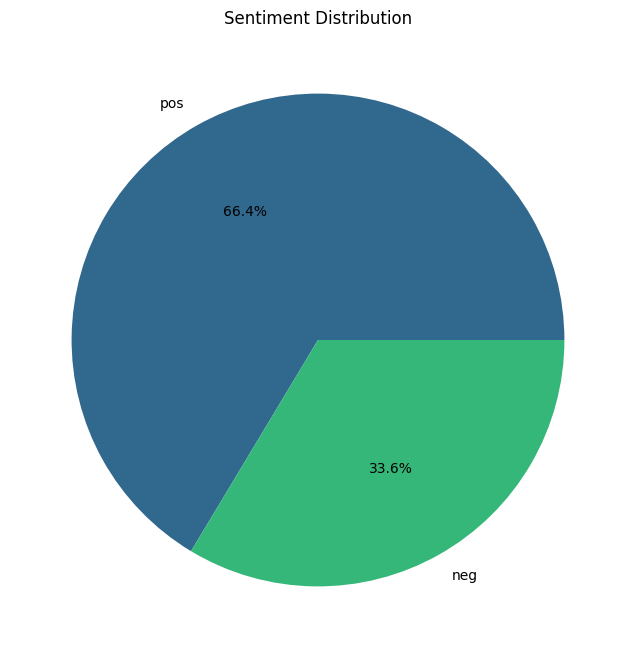

In [ ]:
# Count the sentiments
sentiment_counts = df["sentiment"].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=sns.color_palette("viridis", len(sentiment_counts)))
plt.title("Sentiment Distribution")
plt.show()



In [ ]:
df.head()

reviews              date  \
0  ✅ Trip Verified |   Straightforward check in T...  30th August 2024   
1  Not Verified | I am beyond upset and disgusted...  28th August 2024   
2  ✅ Trip Verified |   I purchased round trip dir...  28th August 2024   
3  Not Verified | I booked two business class sea...  27th August 2024   
4  Not Verified | Although all four flights were ...  26th August 2024   

                                        cleaned_text  \
0  trip verified straightforward check in t new s...   
1  not_ verified i am beyond upset and disgusted ...   
2  trip verified i purchased round trip direct fl...   
3  not_ verified i booked two business class seat...   
4  not_ verified although all four flights were d...   

                                   preprocessed_text  polarity_score sentiment  
0  trip verified straightforward check new site c...          0.8176       pos  
1  not_ verified beyond upset disgusted disregard...         -0.9819       neg  
2  trip verified purchased round trip direct flig...         -0.8701       neg  
3  not_ verified booked business class seat medic...         -0.3400       neg  
4  not_ verified although four flight delayed off...          0.9039       pos

In [ ]:
#encoding sentiments
df["sentiment"] = LabelEncoder().fit_transform(df["sentiment"])

#dividing data train-test-spilt
x_train, x_test, y_train, y_test = train_test_split(df["preprocessed_text"], df["sentiment"], test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape


((3032,), (758,), (3032,), (758,))

In [ ]:
df.head()

reviews              date  \
0  ✅ Trip Verified |   Straightforward check in T...  30th August 2024   
1  Not Verified | I am beyond upset and disgusted...  28th August 2024   
2  ✅ Trip Verified |   I purchased round trip dir...  28th August 2024   
3  Not Verified | I booked two business class sea...  27th August 2024   
4  Not Verified | Although all four flights were ...  26th August 2024   

                                        cleaned_text  \
0  trip verified straightforward check in t new s...   
1  not_ verified i am beyond upset and disgusted ...   
2  trip verified i purchased round trip direct fl...   
3  not_ verified i booked two business class seat...   
4  not_ verified although all four flights were d...   

                                   preprocessed_text  polarity_score  \
0  trip verified straightforward check new site c...          0.8176   
1  not_ verified beyond upset disgusted disregard...         -0.9819   
2  trip verified purchased round trip direct flig...         -0.8701   
3  not_ verified booked business class seat medic...         -0.3400   
4  not_ verified although four flight delayed off...          0.9039   

   sentiment  
0          1  
1          0  
2          0  
3          0  
4          1

#*Develop a sentiment analysis model LSTM*

Epoch 1/10
95/95 - 46s - 479ms/step - accuracy: 0.6702 - loss: 0.8403 - val_accuracy: 0.6187 - val_loss: 0.7952
Epoch 2/10
95/95 - 28s - 295ms/step - accuracy: 0.6837 - loss: 0.7011 - val_accuracy: 0.7098 - val_loss: 0.6028
Epoch 3/10
95/95 - 20s - 210ms/step - accuracy: 0.7272 - loss: 0.6003 - val_accuracy: 0.6781 - val_loss: 0.5944
Epoch 4/10
95/95 - 18s - 184ms/step - accuracy: 0.7028 - loss: 0.5610 - val_accuracy: 0.6979 - val_loss: 0.5724
Epoch 5/10
95/95 - 20s - 214ms/step - accuracy: 0.7164 - loss: 0.5652 - val_accuracy: 0.6187 - val_loss: 0.6849
Epoch 6/10
95/95 - 19s - 195ms/step - accuracy: 0.6969 - loss: 0.5559 - val_accuracy: 0.6095 - val_loss: 0.7258
Epoch 7/10
95/95 - 20s - 206ms/step - accuracy: 0.7361 - loss: 0.5443 - val_accuracy: 0.5858 - val_loss: 0.7084
Epoch 8/10
95/95 - 39s - 413ms/step - accuracy: 0.7589 - loss: 0.4971 - val_accuracy: 0.6398 - val_loss: 0.6384
Epoch 9/10
95/95 - 26s - 272ms/step - accuracy: 0.8278 - loss: 0.3884 - val_accuracy: 0.7058 - val_loss:

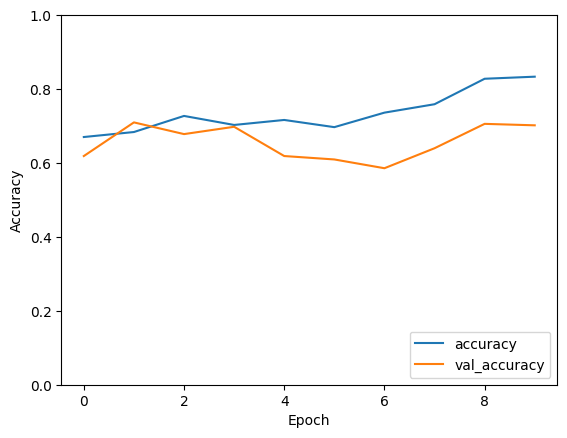

In [ ]:

# Tokenization
vocab_size = 10000  # Increased vocabulary size
max_length = 100
embedding_dim = 100
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(x_train)
x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

# Padding sequences
x_train_padded = pad_sequences(x_train_sequences, maxlen=max_length, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_sequences, maxlen=max_length, padding='post', truncating='post')

# Build the LSTM Model
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),  # Added Bidirectional
    LSTM(32),
    Dense(24, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Added L2 Regularization
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Add early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# from keras.callbacks import ReduceLROnPlateau

# Learning rate scheduler
#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)


# Train the model with validation data
history = model.fit(
    x_train_padded, y_train,
    epochs=10,
    validation_data=(x_test_padded, y_test),
    verbose=2,
    batch_size=32,
    #callbacks=[early_stopping]
)

# Evaluate the model
y_pred_no_imbalance = (model.predict(x_test_padded) > 0.5).astype("int32")
print(classification_report(y_test, y_pred_no_imbalance))

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


# **Implement techniques to handle class imbalance**

### **Oversampling Method**



Epoch 1/15
128/128 - 32s - 247ms/step - accuracy: 0.6356 - loss: 0.7879 - val_accuracy: 0.7652 - val_loss: 0.5333
Epoch 2/15
128/128 - 20s - 153ms/step - accuracy: 0.8324 - loss: 0.4236 - val_accuracy: 0.7955 - val_loss: 0.4490
Epoch 3/15
128/128 - 31s - 239ms/step - accuracy: 0.9196 - loss: 0.2179 - val_accuracy: 0.8034 - val_loss: 0.4963
Epoch 4/15
128/128 - 29s - 230ms/step - accuracy: 0.9563 - loss: 0.1290 - val_accuracy: 0.7863 - val_loss: 0.6230
Epoch 5/15
128/128 - 31s - 243ms/step - accuracy: 0.9787 - loss: 0.0767 - val_accuracy: 0.7863 - val_loss: 0.8429
Epoch 6/15
128/128 - 23s - 178ms/step - accuracy: 0.9924 - loss: 0.0381 - val_accuracy: 0.7731 - val_loss: 0.9152
Epoch 7/15
128/128 - 38s - 295ms/step - accuracy: 0.9919 - loss: 0.0328 - val_accuracy: 0.7678 - val_loss: 1.0026
Epoch 8/15
128/128 - 22s - 169ms/step - accuracy: 0.9951 - loss: 0.0251 - val_accuracy: 0.7770 - val_loss: 1.0902
Epoch 9/15
128/128 - 19s - 145ms/step - accuracy: 0.9971 - loss: 0.0176 - val_accuracy: 

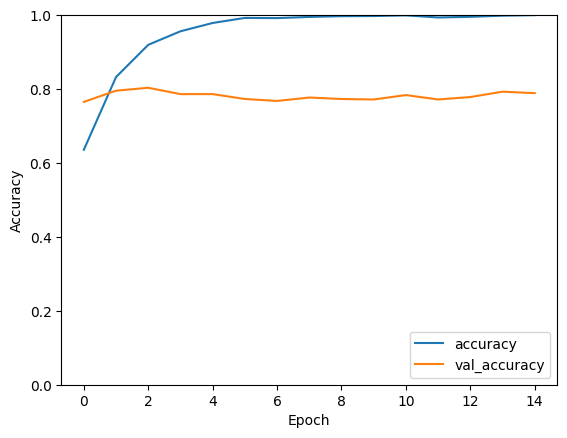

In [ ]:

# Tokenization
vocab_size = 5000
max_length = 100
embedding_dim = 100
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(x_train)
x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

# Padding sequences
x_train_padded = pad_sequences(x_train_sequences, maxlen=max_length, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_sequences, maxlen=max_length, padding='post', truncating='post')

# Apply SMOTE to oversample the minority class
sm = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = sm.fit_resample(x_train_padded, y_train)



# Build the LSTM Model
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    #Bidirectional(LSTM(32)),
    Dense(24, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.6),
    Flatten(), # Added Flatten layer to resolve the shape mismatch
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Add early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# from keras.callbacks import ReduceLROnPlateau

# # Learning rate scheduler
#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

# Train the model
history = model.fit(
    x_train_resampled, y_train_resampled,
    epochs=15,
    validation_data=(x_test_padded, y_test),
    verbose=2,
    batch_size=32
)

# Evaluate the model
y_pred_oversampled = (model.predict(x_test_padded) > 0.5).astype("int32")
print(classification_report(y_test, y_pred_oversampled))

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


### **Undersampling Method**

Epoch 1/15
62/62 - 18s - 292ms/step - accuracy: 0.5020 - loss: 0.9236 - val_accuracy: 0.6187 - val_loss: 0.8887
Epoch 2/15
62/62 - 12s - 197ms/step - accuracy: 0.5142 - loss: 0.8644 - val_accuracy: 0.6227 - val_loss: 0.8370
Epoch 3/15
62/62 - 21s - 339ms/step - accuracy: 0.5812 - loss: 0.7989 - val_accuracy: 0.5290 - val_loss: 0.7641
Epoch 4/15
62/62 - 20s - 317ms/step - accuracy: 0.7401 - loss: 0.6508 - val_accuracy: 0.7929 - val_loss: 0.5556
Epoch 5/15
62/62 - 12s - 199ms/step - accuracy: 0.8218 - loss: 0.5694 - val_accuracy: 0.7454 - val_loss: 0.6129
Epoch 6/15
62/62 - 19s - 314ms/step - accuracy: 0.8239 - loss: 0.5510 - val_accuracy: 0.7269 - val_loss: 0.7334
Epoch 7/15
62/62 - 12s - 198ms/step - accuracy: 0.6254 - loss: 0.7093 - val_accuracy: 0.7216 - val_loss: 0.6674
Epoch 8/15
62/62 - 20s - 321ms/step - accuracy: 0.6853 - loss: 0.6337 - val_accuracy: 0.7269 - val_loss: 0.6768
Epoch 9/15
62/62 - 21s - 338ms/step - accuracy: 0.7127 - loss: 0.6388 - val_accuracy: 0.5818 - val_loss:

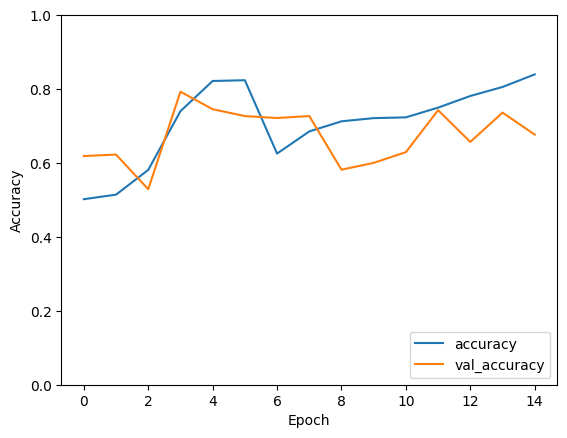

In [ ]:

# Tokenization
vocab_size = 5000
max_length = 100
embedding_dim = 100
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(x_train)
x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

# Padding sequences
x_train_padded = pad_sequences(x_train_sequences, maxlen=max_length, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_sequences, maxlen=max_length, padding='post', truncating='post')

# Apply undersampling to the majority class
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
x_train_resampled, y_train_resampled = undersample.fit_resample(x_train_padded, y_train)

# Build the LSTM Model
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),  # Using Bidirectional LSTM
    LSTM(32),
    Dense(24, activation='relu', kernel_regularizer=l2(0.01)),  # L2 Regularization
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0005),  # Reduced learning rate
              metrics=['accuracy'])


# Train the model
history = model.fit(
    x_train_resampled,
    y_train_resampled,
    epochs=15,
    validation_data=(x_test_padded, y_test),
    verbose=2,
    batch_size=32,
    #callbacks=[early_stopping, model_checkpoint, lr_scheduler]  # Add callbacks here
)

# Evaluate the model
y_pred_undersampled = (model.predict(x_test_padded) > 0.5).astype("int32")
print(classification_report(y_test, y_pred_undersampled))

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


### **Class Weights Method**

In [ ]:
#again spliting data for this method
x_train, x_test, y_train, y_test = train_test_split(df["preprocessed_text"], df["sentiment"], test_size=0.2, random_state=42)
y_train = y_train.reset_index(drop=True)


In [ ]:
# Compute class weights based on actual labels
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Updated Class Weights:", class_weights_dict)


Updated Class Weights: {0: 1.5390862944162436, 1: 0.7405959941377626}


Epoch 1/10
95/95 - 19s - 198ms/step - accuracy: 0.5676 - loss: 0.8568 - val_accuracy: 0.7784 - val_loss: 0.5526
Epoch 2/10
95/95 - 14s - 142ms/step - accuracy: 0.8123 - loss: 0.4681 - val_accuracy: 0.8285 - val_loss: 0.4481
Epoch 3/10
95/95 - 20s - 215ms/step - accuracy: 0.9123 - loss: 0.2505 - val_accuracy: 0.8338 - val_loss: 0.4510
Epoch 4/10
95/95 - 21s - 218ms/step - accuracy: 0.9650 - loss: 0.1139 - val_accuracy: 0.8219 - val_loss: 0.4801
Epoch 5/10
95/95 - 13s - 138ms/step - accuracy: 0.9782 - loss: 0.0747 - val_accuracy: 0.8232 - val_loss: 0.6388
Epoch 6/10
95/95 - 21s - 220ms/step - accuracy: 0.9802 - loss: 0.0620 - val_accuracy: 0.8298 - val_loss: 0.8133
Epoch 7/10
95/95 - 20s - 206ms/step - accuracy: 0.9918 - loss: 0.0327 - val_accuracy: 0.8153 - val_loss: 0.8253
Epoch 8/10
95/95 - 13s - 132ms/step - accuracy: 0.9911 - loss: 0.0308 - val_accuracy: 0.8074 - val_loss: 0.8190
Epoch 9/10
95/95 - 21s - 226ms/step - accuracy: 0.9937 - loss: 0.0203 - val_accuracy: 0.8100 - val_loss:

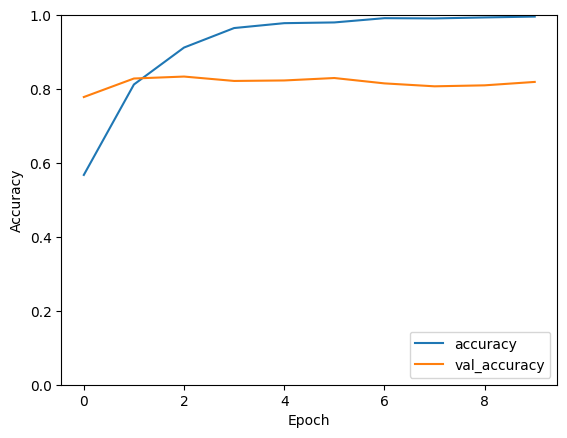

In [ ]:
# Tokenization
vocab_size = 5000
max_length = 100
embedding_dim = 100
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(x_train)
x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)
# Padding sequences
vocab_size = 5000
max_length = 100
embedding_dim = 100

x_train_padded= pad_sequences(x_train_sequences, maxlen=max_length, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_sequences, maxlen=max_length, padding='post', truncating='post')


# Build the LSTM Model
model = Sequential([
      Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    #Bidirectional(LSTM(32)),
    Dense(24, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.6),
    Flatten(), # Added Flatten layer to resolve the shape mismatch
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])



# Train the model with class weights
history = model.fit(
    x_train_padded,
    y_train,
    epochs=10,
    validation_data=(x_test_padded, y_test),
    verbose=2,
    batch_size=32,
    class_weight=class_weights_dict
)


# Evaluate the model
y_pred_class_weight = (model.predict(x_test_padded) > 0.5).astype("int32")
print(classification_report(y_test, y_pred_class_weight))


plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()



In [ ]:
# Create the data for the table, rounding the values to 4 decimal places
data = [
    [" LSTM (No Imbalance Method) ",  0.701847, 0.700342,  0.701847, 0.701015],
    ["LSTM (Oversampled)", 0.788918,  0.788389 , 0.788918, 0.788918],
    ["LSTM (Undersampled)", 0.676781,  0.772032 ,  0.676781, 0.674896 ],
    ["LSTM (Class Weight) ",  0.819261,  0.818361, 0.819261,  0.818691]
]

# Define the column headers
headers = ["Model", "Accuracy", "Precision", "Recall", "F1-Score", ]

# Print the table using tabulate with rounding
print(tabulate(data, headers, tablefmt="pretty", floatfmt=".2f"))



+----------------------------+----------+-----------+----------+----------+
|           Model            | Accuracy | Precision |  Recall  | F1-Score |
+----------------------------+----------+-----------+----------+----------+
| LSTM (No Imbalance Method) | 0.701847 | 0.700342  | 0.701847 | 0.701015 |
|     LSTM (Oversampled)     | 0.788918 | 0.788389  | 0.788918 | 0.788918 |
|    LSTM (Undersampled)     | 0.676781 | 0.772032  | 0.676781 | 0.674896 |
|    LSTM (Class Weight)     | 0.819261 | 0.818361  | 0.819261 | 0.818691 |
+----------------------------+----------+-----------+----------+----------+


### Conclusion:

* Among the different approaches to handle class imbalance, using **Class
Weight** adjustments offers the best overall performance, followed by **Oversampling**.
* The **Undersampled** model, while having higher precision, suffers in accuracy and recall.
* The **No Imbalance Method** serves as a baseline and is outperformed by all other methods in this comparison.

# Perform error analysis and model interpretation

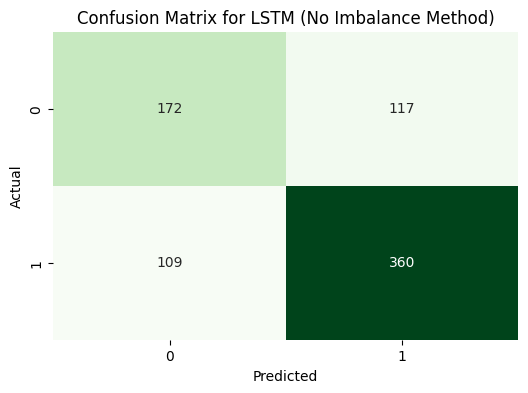

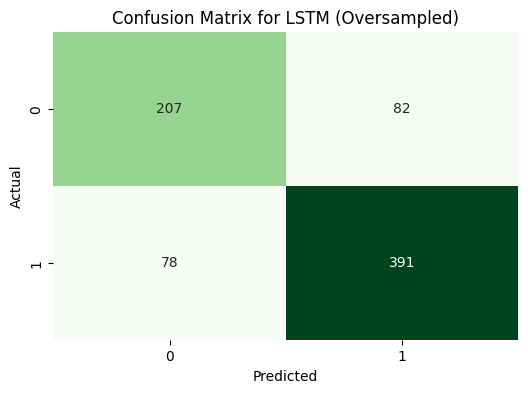

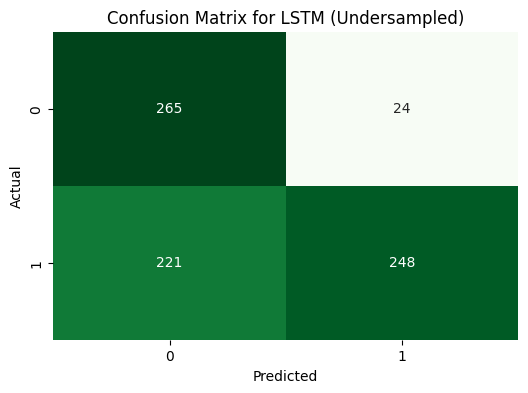

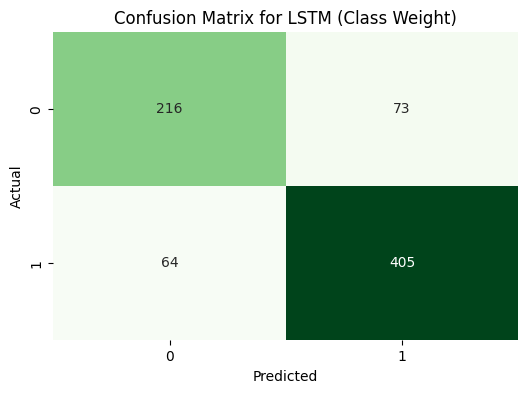

In [ ]:
# y_test and y_pred for each model are defined
y_preds = {
    'LSTM (No Imbalance Method)': y_pred_no_imbalance,
    'LSTM (Oversampled)': y_pred_oversampled,
    'LSTM (Undersampled)': y_pred_undersampled,
    'LSTM (Class Weight)': y_pred_class_weight
}

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrices for each model
for model_name, y_pred in y_preds.items():
    plot_confusion_matrix(y_test, y_pred, model_name)


In [ ]:

# Ensure y_pred is a NumPy array and correctly shaped
y_pred = np.array(y_pred).flatten()

# Find misclassified indices
misclassified_indices = np.where(y_test != y_pred)[0]

# Check if misclassified_indices are within the valid range
if len(misclassified_indices) > 0:
    # Ensure x_test and y_test are correctly indexed
    misclassified_texts = x_test.iloc[misclassified_indices]
    misclassified_preds = y_pred[misclassified_indices]

    # Display first 5 misclassified samples
    for i in range(min(5, len(misclassified_texts))):  # Display up to 5 errors
        print(f"Text: {misclassified_texts.iloc[i]}")
        print(f"True Sentiment: {y_test.iloc[misclassified_indices[i]]}, Predicted Sentiment: {misclassified_preds[i]}")
        print("-" * 50)
else:
    print("No misclassified samples found.")


Text: flew lhr denver colorado ski holiday absolutely disappointed outraged rubbish food served flight obviously consider edible ba class edible shall truly disagree awful food coffee rubbish asked water never got inflight entertainment also poor film stopped minute reboot system passenger male steward fine happy female stewardess miserable felt putting asking drink never arrived anyway thought ba got rid superior lucky fly u attitude not_ fly help
True Sentiment: 0, Predicted Sentiment: 1
--------------------------------------------------
Text: lack customer call centre cabin crew not_ seated next husband hour flight thoroughly disappointed british airway husband travelled separate booking flying back london sydney together phoned british airway day flight london ask link booking number would seated flight together informed could link number not_ guarantee would seated next however wanted buy seat advance would guaranteed not_ giving moneygrabbing airline another opportunity take mone

In [ ]:

# Initialize LIME Explainer
explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])

# Define a wrapper function that takes raw text and processes it for the model
def wrapped_predict(texts):
    # Tokenize the texts
    sequences = tokenizer.texts_to_sequences(texts)
    # Pad the sequences
    padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    # Predict using the model
    predictions = model.predict(padded)
    # Since it's binary classification, return an array with two columns: P(class 0) and P(class 1)
    return np.hstack((1 - predictions, predictions))

# Index of the instance to explain
i = 10

# Get the original text instance
instance_text = x_test.iloc[i]

# Explain the prediction using the raw text and the wrapped predict function
exp = explainer.explain_instance(instance_text, wrapped_predict, num_features=6)

# Show the explanation
exp.show_in_notebook(text=True)

exp.show_in_notebook(text=True)


157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step


# Create a visualization dashboard for sentiment trends

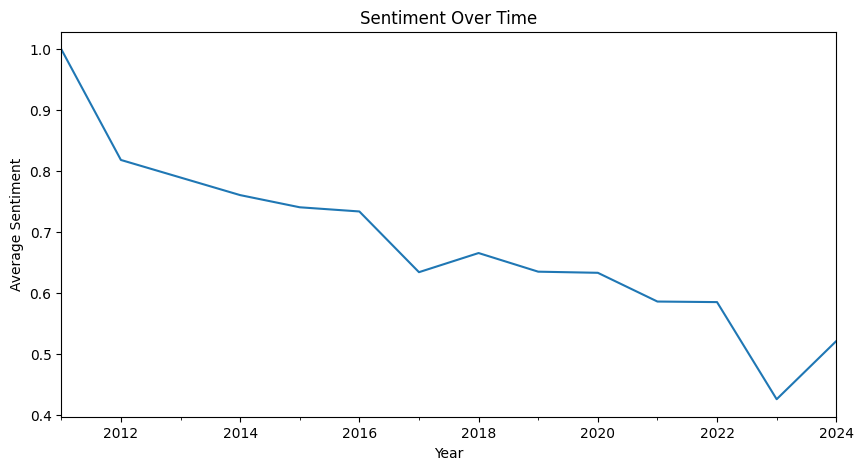

In [ ]:
# Attempt to convert the 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Group by year and calculate mean sentiment, handling potential empty groups
sentiment_trend = df.groupby(df['date'].dt.to_period('Y'))['sentiment'].mean().dropna()

plt.figure(figsize=(10, 5))
# Check if sentiment_trend is empty before plotting
if not sentiment_trend.empty:
    sentiment_trend.plot()
    plt.title('Sentiment Over Time')
    plt.xlabel('Year')
    plt.ylabel('Average Sentiment')
    plt.show()
else:
    print("No valid data to plot. Check the 'date' and 'sentiment' columns.")

<Figure size 1200x600 with 0 Axes>

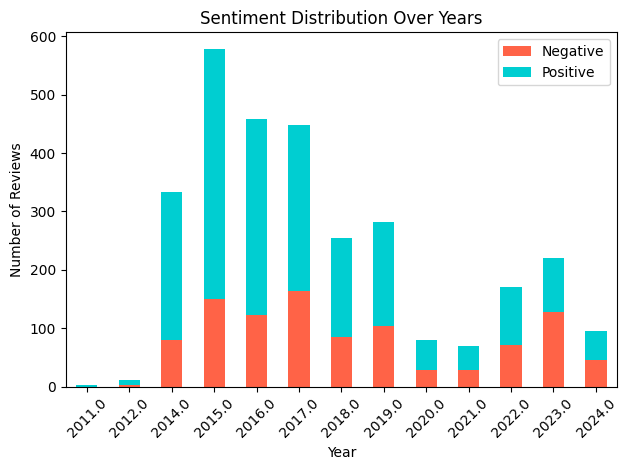

In [ ]:
# Group by year and sentiment
df['year'] = df['date'].dt.year
sentiment_counts = df.groupby(['year', 'sentiment']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(12, 6))
sentiment_counts.plot(kind='bar', stacked=True, color=['tomato', 'darkturquoise'])
plt.title('Sentiment Distribution Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.legend(['Negative', 'Positive'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

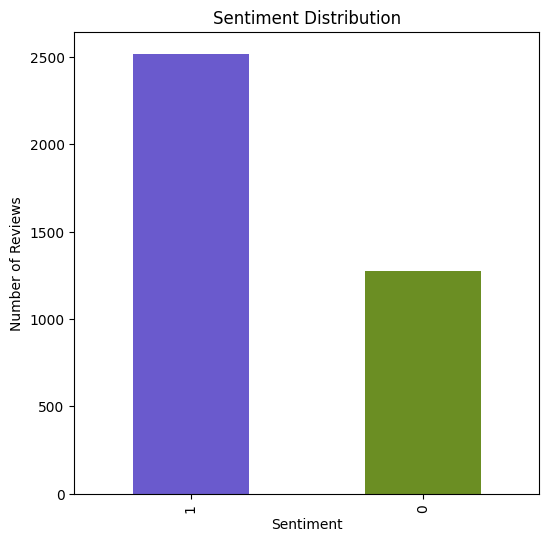

In [ ]:
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(6, 6))
sentiment_counts.plot(kind='bar', color=['slateblue', 'olivedrab'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()


# Summary of Trends

* Overall, the trend shows a general decline in sentiment over the years, with a brief recovery at the end.
* This indicates that customer satisfaction has generally decreased over time, but there may be recent efforts or changes leading to slight improvements.
* The chart shows fluctuations in review volume and sentiment over the years, with a significant peak in reviews around 2015 and a general increase in negative sentiment in the later years.